In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG
import os
import pydotplus

import keras
from keras.optimizers import Adam, SGD, rmsprop
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout, Input, Dropout, concatenate
from keras.layers.recurrent import GRU, LSTM
from keras.utils import plot_model
# keras.utils.vis_utils.pydot = pydot
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = np.load("drive/My Drive/imputed-normed-ep_1_24.npz", allow_pickle=True)

In [0]:
features_sequence = data['ep_tdata'].astype(np.float32) # 12 time series features
features_static = data['adm_features_all'].astype(np.float32) # 5 non-ts features,the unit of age: day
labels = data["adm_labels_all"][:, 0].astype(np.float32) # In-hospital mortality

In [0]:
trans = [0]*features_sequence.shape[0]

In [0]:
for i in range(features_sequence.shape[0]):
    trans[i] = features_sequence[i].T

In [0]:
trans= np.array(trans)

In [9]:
trans.shape

(36093, 12, 24)

In [0]:
features_sequence = trans

In [0]:
x_seq_full_train, x_seq_test, x_static_full_train, x_static_test, y_full_train, y_test = train_test_split(
    features_sequence, features_static, labels, test_size = 0.20, random_state = 202)

x_seq_train, x_seq_val, x_static_train, x_static_val, y_train, y_val = train_test_split(
    x_seq_full_train, x_static_full_train, y_full_train, test_size = 0.20, random_state = 202)

In [12]:
len(y_val)

5775

In [13]:
# Count the positive labels
count = 0
for i in range(y_train.shape[0]):
    if y_train[i] == 1:
        count += 1
count

2625

In [0]:
# upsampling
x_seq_up = []
x_static_up = []
y_up = []
for i in range(x_seq_train.shape[0]):
    count = 0
    if y_train[i] == 1:
        while count < 5:
            x_seq_up.append(x_seq_train[i])
            x_static_up.append(x_static_train[i])
            y_up.append(y_train[i])
            count += 1

In [15]:
print(len(x_seq_up), len(x_static_up), len(y_up))

13125 13125 13125


In [0]:
a = np.concatenate((x_seq_train, x_seq_up))
b = np.concatenate((x_static_train, x_static_up))
c = np.concatenate((y_train, y_up))

In [17]:
index = list(range(len(c)))
np.random.shuffle(index)

x_seq_train = []
x_static_train = []
y_train = []

for i in index:
    x_seq_train.append(a[i])
    x_static_train.append(b[i])
    y_train.append(c[i])

print(len(x_seq_train), len(x_static_train), len(y_train))

36224 36224 36224


In [18]:
x_seq_train  = np.array(x_seq_train)
x_static_train = np.array(x_static_train)
y_train = np.array(y_train)

print(x_seq_train.shape, x_static_train.shape, y_train.shape)

(36224, 12, 24) (36224, 5) (36224,)


In [0]:

def impute_mean(source_data, input_data):
    '''
    Takes the source data, and uses it to determine means for all
    features; it then applies them to the input data.
    
    inputs:
    source_data: a tensor to provide means
    input_data: the data to fill in NA for
    
    output:
    output_data: data with nans imputed for each feature
    
    '''
    
    output_data = input_data.copy()
    
    for feature in range(source_data.shape[1]):
        feature_mean = np.nanmean(source_data[:, feature, :][np.where(source_data[:, feature, :] != 0)])
        ind_output_data = np.where(np.isnan(output_data[:, feature, :]))
        output_data[:, feature, :][ind_output_data] = feature_mean
    return output_data

In [0]:
x_seq_train_original = x_seq_train.copy()
x_seq_train = impute_mean(x_seq_train_original, x_seq_train)
x_seq_val = impute_mean(x_seq_train_original, x_seq_val)
x_seq_test = impute_mean(x_seq_train_original, x_seq_test)

In [21]:
x_seq_train_original.shape

(36224, 12, 24)

In [33]:
# Define inputs
sequence_input = Input(shape = (x_seq_train.shape[1], x_seq_train.shape[2], ), dtype = 'float32', name = 'sequence_input')
static_input = Input(shape = (x_static_train.shape[1], ), name = 'static_input')
# sequence_input = Masking(mask_value=-1, input_shape=(x_seq_train.shape[1], x_seq_train.shape[2], ))(sequence_input)
# model.add(Masking(mask_value=0., input_shape=(timesteps, features)))
# Network architecture
seq_x = GRU(units = 128)(sequence_input)

# Seperate output for the GRU later
seq_aux_output = Dense(1, activation='sigmoid', name='aux_output')(seq_x)

# Merge dual inputs
x = concatenate([seq_x, static_input])

# We stack a deep fully-connected network on the merged inputs
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.10)(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
# Sigmoid output layer
main_output = Dense(1, activation='sigmoid', name='main_output')(x)

# optimizer
opt = Adam(lr = 0.0001)

# build model
model = Model(inputs = [sequence_input, static_input], outputs = [main_output, seq_aux_output])
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'], loss_weights = [1, 0.1])

# save a plot of the model
#plot_model(model, to_file='experiment_GRU-DO.svg')

# fit the model
history = model.fit([x_seq_train, x_static_train], [y_train, y_train], epochs = 80, batch_size = 128,\
                    validation_data=([x_seq_val, x_static_val], [y_val, y_val]),)

Train on 36224 samples, validate on 5775 samples
Epoch 1/80
36224/36224 [==============================] - 10s 278us/step - loss: 40.4729 - main_output_loss: 40.4063 - aux_output_loss: 0.6654 - main_output_accuracy: 0.5047 - aux_output_accuracy: 0.5976 - val_loss: 0.5583 - val_main_output_loss: 0.5016 - val_aux_output_loss: 0.5617 - val_main_output_accuracy: 0.8878 - val_aux_output_accuracy: 0.8549
Epoch 2/80
36224/36224 [==============================] - 9s 261us/step - loss: 11.3121 - main_output_loss: 11.2481 - aux_output_loss: 0.6401 - main_output_accuracy: 0.5072 - aux_output_accuracy: 0.6403 - val_loss: 0.8868 - val_main_output_loss: 0.8213 - val_aux_output_loss: 0.5422 - val_main_output_accuracy: 0.8878 - val_aux_output_accuracy: 0.8376
Epoch 3/80
36224/36224 [==============================] - 10s 263us/step - loss: 6.5296 - main_output_loss: 6.4678 - aux_output_loss: 0.6188 - main_output_accuracy: 0.5090 - aux_output_accuracy: 0.6658 - val_loss: 1.1475 - val_main_output_loss: 1

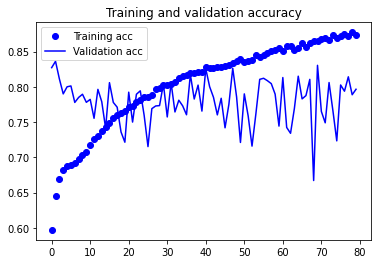

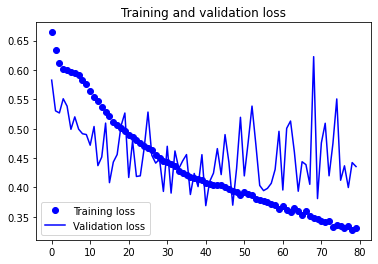

In [0]:
# round 1
# in-hospital mortality prediction
# plot training and validation loss and accuracy

acc = history.history['aux_output_accuracy']
val_acc = history.history['val_aux_output_accuracy']
loss = history.history['aux_output_loss']
val_loss = history.history['val_aux_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# fig_name = 'loss_svg.svg'
# fig.savefig('loss_svg.svg', bbox_inches='tight')

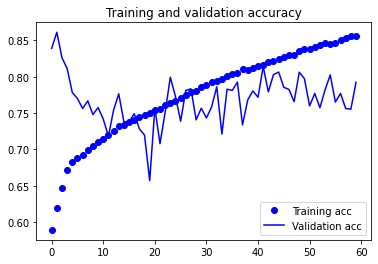

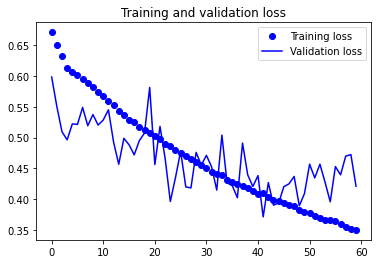

In [0]:
# round 2
# in-hospital mortality prediction
# plot training and validation loss and accuracy

acc = history.history['aux_output_accuracy']
val_acc = history.history['val_aux_output_accuracy']
loss = history.history['aux_output_loss']
val_loss = history.history['val_aux_output_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# fig_name = 'loss_svg.svg'
# fig.savefig('loss_svg.svg', bbox_inches='tight')

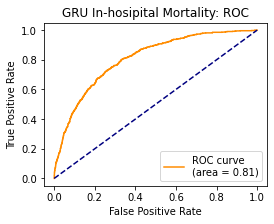

In [0]:
# Round 1
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

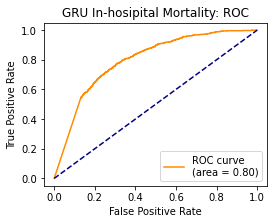

In [36]:
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_main)
auc = roc_auc_score(y_test, pred_main)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

In [37]:
#auprc
average_precision = average_precision_score(y_test, pred_aux)
average_precision 

0.34291651387057787

In [38]:
#auprc
average_precision = average_precision_score(y_test, pred_main)
average_precision 

0.2794535605685761

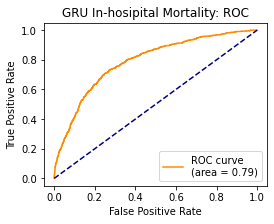

In [0]:
# Round 2
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()

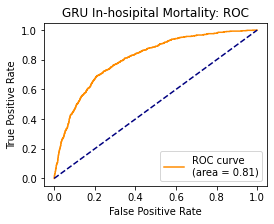

In [0]:
# Round 2
# AUC for the in-hospital mortality prediction
pred_main, pred_aux = model.predict([x_seq_test, x_static_test])
roc = roc_curve(y_test, pred_aux)
auc = roc_auc_score(y_test, pred_aux)
fig = plt.figure(figsize=(4, 3)) # in inches
plt.plot(roc[0], roc[1], color = 'darkorange', label = 'ROC curve\n(area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color= 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s: ROC' % 'GRU In-hosipital Mortality')
plt.legend(loc = "lower right")
# fig_name = 'gru-base.pdf'
# fig.savefig(fig_name, bbox_inches='tight')
plt.show()